## Simulation Workbook

#### Reference
- https://github.com/MonashRobotics/ECE4191/blob/main/RPI/Python_resources/Navigation/Robot_navigation_and_control.ipynb
- https://github.com/AtsushiSakai/PythonRobotics/tree/master

In [38]:
import math
import matplotlib.pyplot as plt
import numpy as np
from IPython import display


In [2]:
# Vehicle parameters
LENGTH = 4.5  # 
WIDTH = 2.0  # 
BACKTOWHEEL = 1.0  # 
WHEEL_LEN = 0.3  # 
WHEEL_WIDTH = 0.2  # 
TREAD = 0.7  # 
WB = 2.5  # 

- We first define the vehicle parameters here, changing these parameters will change how the vehicle is displayed in the simulation.
- However, the units for each of the parameters above have yet to be defined.

In [3]:
class State:
    '''
    Vehicle State

    Args:
        x: the x position of an object in the plot.
        y: the y position of an object in the plot.
        yaw: the yaw of the object.
        v: the velocity of the object.
        steer: the front steering wheeel.
    '''
    def __init__(self, x=0.0, y=0.0, yaw=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw

In [64]:
class DiffDriveRobot:
    '''
    Differential Drive Robot Class
    Source of Reference: https://github.com/MonashRobotics/ECE4191/blob/main/RPI/Python_resources/Navigation/Robot_navigation_and_control.ipynb
    To learn more about differential robots: https://msl.cs.uiuc.edu/planning/node659.html.
 
    Args:
        initial_state: Initial State of the vehicle.
        inertia: the estimated inertia (difficulty to move) of the vehicle.
        dt: the discrete time step of the vehicle.
        drag: drag as result of primarily the raod surface.
        wheel_radius: the estimated wheel radius.
        wheel_sp: the estiamted wheel sepearation.
    '''
    def __init__(self, 
                 initial_state: State, 
                 inertia=5, 
                 dt=0.1, 
                 drag=0.2, 
                 wheel_radius=5, 
                 wheel_sep=15,
                 Kp = 0.1,
                 Ki = 0.01):
        # Vehicle State Variables
        self.x = initial_state.x # y-position
        self.y = initial_state.y# y-position 
        self.yaw = initial_state.yaw # orientation
        self.current_state = State(self.x, self.y, self.yaw)

        # Vehicle Kinematics Variables
        self.wl = 0.0 #rotational velocity left wheel
        self.wr = 0.0 #rotational velocity right wheel
        
        # Dynamic Constants
        self.I = inertia
        self.d = drag
        self.dt = dt
        self.r = wheel_radius
        self.l = wheel_sep

        # Controller Constants
        self.Kp = Kp
        self.Ki = Ki
        self.e_sum_l = 0
        self.e_sum_r = 0

    # Private Function: Here, we simulate the real system and measurement
    def __motor_simulator__(self,w,duty_cycle):
        
        torque = self.I*duty_cycle
        
        if (w > 0):
            w = min(w + self.dt*(torque - self.d*w),3)
        elif (w < 0):
            w = max(w + self.dt*(torque - self.d*w),-3)
        else:
            w = w + self.dt*(torque)
        
        return w
    
    # Private Function: Veclocity motion model
    def __base_velocity__(self,wl,wr):
        
        v = (wl*self.r + wr*self.r)/2.0
        
        w = (wl*self.r - wr*self.r)/self.l
        
        return v, w
    
    # Private Function: The PI controller
    # A very good tutorial for PI controller: https://www.digikey.com/en/maker/projects/introduction-to-pid-controllers/763a6dca352b4f2ba00adde46445ddeb#:~:text=PID%20Controller%20Overview&text=PID%20stands%20for%20%E2%80%9CProportional%2C%20Integral,term%20is%20accumulated%20over%20time.
     
    def __p_control__(self,w_desired,w_measured,e_sum):
        
        duty_cycle = min(max(-1,self.Kp*(w_desired-w_measured) + self.Ki*e_sum),1)
        
        e_sum = e_sum + (w_desired-w_measured)
        
        return duty_cycle, e_sum

    # Kinematic motion model
    def pose_update(self,v_desired,w_desired, wl, wr):
        """
        Args:
            v_desired: the desired linear velocity of the vehicle.
            w_desired: the desired angular velocity of the vehicle.
            wl: the current left wheel angular velocity 
            wr: the current right wheel angular velocity
        """
        # Calculate the desired velocity of the two wheels on either side
        wl_desired = (v_desired + self.l*w_desired/2)/self.r
        wr_desired = (v_desired - self.l*w_desired/2)/self.r

        # Calculate the duty_cycle of the actuation
        duty_cycle_l,self.e_sum_l = self.__p_control__(wl_desired,wl,self.e_sum_l)
        duty_cycle_r,self.e_sum_r = self.__p_control__(wr_desired,wr,self.e_sum_r)

        self.wl = self.__motor_simulator__(self.wl,duty_cycle_l)
        self.wr = self.__motor_simulator__(self.wr,duty_cycle_r)
        
        v, w = self.__base_velocity__(self.wl,self.wr)
        
        self.x = self.x + self.dt*v*np.cos(self.yaw)
        self.y = self.y + self.dt*v*np.sin(self.yaw)
        self.yaw = self.yaw + w*self.dt
        self.current_state = State(self.x, self.y, self.yaw)

        return self.current_state

In [59]:
class Car(DiffDriveRobot):
    '''
    Vehicle Class

    Args:
        x: the State variable
        initial_state: The Starting State of the vehicle
        color: color of car
    '''
    def __init__(self, initial_state: State, color ="-k"):
        super().__init__(initial_state = initial_state)
        # Initialize the vehicle state
        self.state = initial_state
        self.color = color
    
    def drive(self,v_desired,w_desired, wl, wr):
        self.state = self.pose_update(v_desired,w_desired, wl, wr)
        #print(self.state.x)
        #print(self.state.y)
        return self.state

    def plot_car(self, new_state: State = None, ax = None):  # pragma: no cover
        '''
        Inherited from: https://github.com/AtsushiSakai/PythonRobotics/tree/master?tab=readme-ov-file
        This will plot the 2d vehicle in the Simulation.

        Args: 
             new_state: the next state to be plotted
             ax: the axis which the plot is to be made on
        '''
        if new_state is None:
                x = self.state.x
                y = self.state.y
                yaw = self.state.yaw
        
        x = new_state.x
        y = new_state.y
        yaw = new_state.yaw
        
        truckcolor= self.color

        outline = np.array([[-BACKTOWHEEL, (LENGTH - BACKTOWHEEL), (LENGTH - BACKTOWHEEL), -BACKTOWHEEL, -BACKTOWHEEL],
                            [WIDTH / 2, WIDTH / 2, - WIDTH / 2, -WIDTH / 2, WIDTH / 2]])

        fr_wheel = np.array([[WHEEL_LEN, -WHEEL_LEN, -WHEEL_LEN, WHEEL_LEN, WHEEL_LEN],
                            [-WHEEL_WIDTH - TREAD, -WHEEL_WIDTH - TREAD, WHEEL_WIDTH - TREAD, WHEEL_WIDTH - TREAD, -WHEEL_WIDTH - TREAD]])

        rr_wheel = np.copy(fr_wheel)

        fl_wheel = np.copy(fr_wheel)
        fl_wheel[1, :] *= -1
        rl_wheel = np.copy(rr_wheel)
        rl_wheel[1, :] *= -1

        Rot1 = np.array([[math.cos(yaw), math.sin(yaw)],
                        [-math.sin(yaw), math.cos(yaw)]])
        Rot2 = np.array([[math.cos(0), math.sin(0)],
                        [-math.sin(0), math.cos(0)]])

        fr_wheel = (fr_wheel.T.dot(Rot2)).T
        fl_wheel = (fl_wheel.T.dot(Rot2)).T
        fr_wheel[0, :] += WB
        fl_wheel[0, :] += WB

        fr_wheel = (fr_wheel.T.dot(Rot1)).T
        fl_wheel = (fl_wheel.T.dot(Rot1)).T

        outline = (outline.T.dot(Rot1)).T
        rr_wheel = (rr_wheel.T.dot(Rot1)).T
        rl_wheel = (rl_wheel.T.dot(Rot1)).T

        outline[0, :] += x
        outline[1, :] += y
        fr_wheel[0, :] += x
        fr_wheel[1, :] += y
        rr_wheel[0, :] += x
        rr_wheel[1, :] += y
        fl_wheel[0, :] += x
        fl_wheel[1, :] += y
        rl_wheel[0, :] += x
        rl_wheel[1, :] += y
        
        
        ax.plot(np.array(outline[0, :]).flatten(),
                np.array(outline[1, :]).flatten(), truckcolor)
        ax.plot(np.array(fr_wheel[0, :]).flatten(),
                np.array(fr_wheel[1, :]).flatten(), truckcolor)
        ax.plot(np.array(rr_wheel[0, :]).flatten(),
                np.array(rr_wheel[1, :]).flatten(), truckcolor)
        ax.plot(np.array(fl_wheel[0, :]).flatten(),
                np.array(fl_wheel[1, :]).flatten(), truckcolor)
        ax.plot(np.array(rl_wheel[0, :]).flatten(),
                np.array(rl_wheel[1, :]).flatten(), truckcolor)
        ax.plot(x, y, "*")
        return ax
        

In [60]:

class Room:
    def __init__(self, width=50, height=50):
        self.width = width
        self.height = height
        self.room = np.zeros((self.height, self.width))  # Initialize room with zeros
    
    def add_rectangle_border(self, x, y, rect_width, rect_height, value=1):
        # Add top border
        self.room[y:y+1, x:x+rect_width] = value
        # Add bottom border
        self.room[y+rect_height-1:y+rect_height, x:x+rect_width] = value
        # Add left border
        self.room[y:y+rect_height, x:x+1] = value
        # Add right border
        self.room[y:y+rect_height, x+rect_width-1:x+rect_width] = value
    
    def draw(self, ax):
        ax.imshow(self.room, cmap='binary', interpolation='nearest')
        ax.set_title('Room Layout')
        ax.set_xlabel('Width (pixels)')
        ax.set_ylabel('Height (pixels)')

        return ax


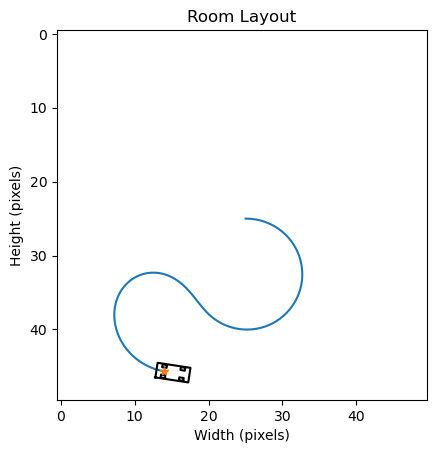

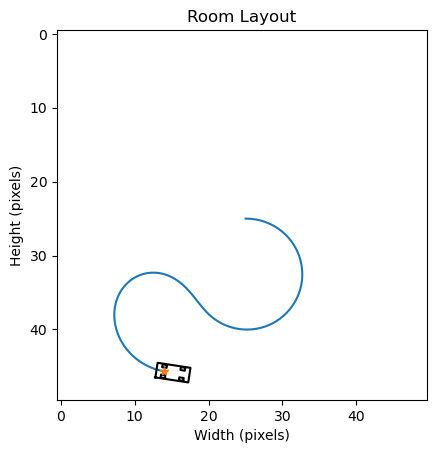

In [63]:
# Vectors to track vehicle positions
poses = []

# Initiate the Initial State Variable
state_start = State(25, 25, 0)
car = Car(state_start)


# De fine the subplot Environment
plot = plt.subplot(1,1,1)
for i in range(200):
    # Clear the Sand Box
    plot.clear()

    # Draw the Room
    room = Room()

    # Plot the robot
    room.draw(plot)
    if i < 100: # drive in circular path (turn left) for 10 s
        current_state = car.pose_update(3,0.4,car.wl,car.wr)
        
    elif i > 100: # drive in circular path (turn right) for 10 s
        current_state = car.pose_update(3,-0.4,car.wl,car.wr)
        
    poses.append([current_state.x,
                  current_state.y,
                  current_state.yaw])
    
    # Plot the path of the robot.
    plot.plot(np.array(poses)[:,0],np.array(poses)[:,1])
        
    plot = car.plot_car(ax = plot, new_state = current_state)
    
    # Display the plot
    display.clear_output(wait=True)
    display.display(plt.gcf())

    